In [1]:
import scanpy as sc
import celltypist
import numpy as np
import pandas as pd

# load data

In [2]:
adata_merge = sc.read_h5ad("ForAnno.h5ad")

In [3]:
adata_merge.obs_names_make_unique()

In [4]:
# ## renormalize
adata_anno2 = adata_merge.copy()
adata_anno2.X = np.expm1(adata_anno2.X)
sc.pp.normalize_total(adata_anno2, target_sum=1e4)
sc.pp.log1p(adata_anno2)

# scrublet

In [5]:
import scrublet as scr
import scipy.sparse
import matplotlib.pyplot as plt

In [8]:
counts_matrix = adata_anno2.X

In [10]:
if not isinstance(counts_matrix, scipy.sparse.csc_matrix):
    counts_matrix = scipy.sparse.csc_matrix(counts_matrix)

In [20]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 39.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.1%
Elapsed time: 10.9 seconds


In [21]:
adata_anno2.obs['doublet_scores'] = doublet_scores
adata_anno2.obs['predicted_doublets'] = predicted_doublets
adata_anno2.obs['predicted_doublets'] = adata_anno2.obs['predicted_doublets'].astype(str)

... storing 'predicted_doublets' as categorical


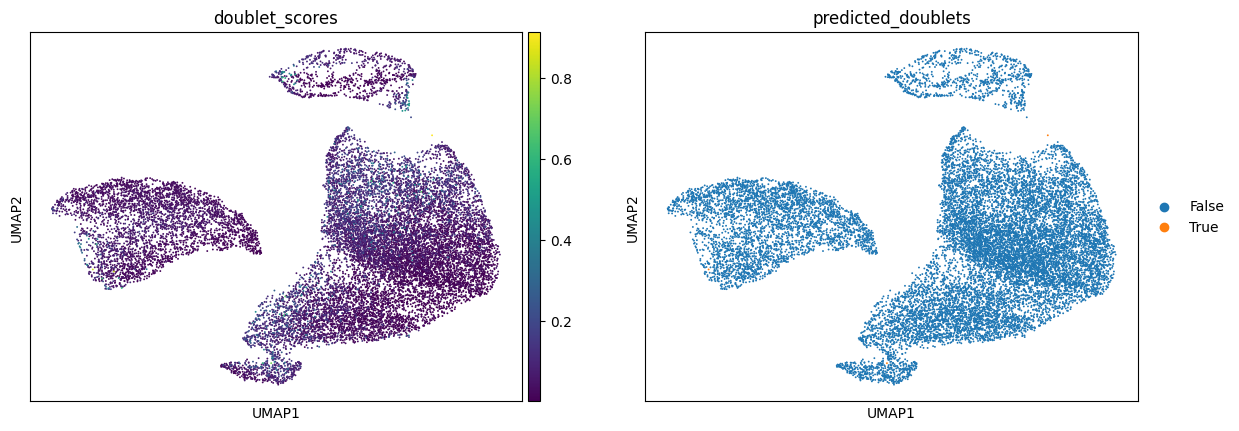

In [22]:
sc.pl.umap(adata_anno2,color=["doublet_scores", "predicted_doublets"])

# anno with celltypist

In [6]:
predictions = celltypist.annotate(adata_anno2, model = '../Aging/Healthy_Adult_Heart.pkl', majority_voting = True,)

🔬 Input data has 16600 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 1312 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [7]:
predictions.predicted_labels['predicted_labels'].value_counts()

EC6_ven             4830
EC3_cap             4327
EC5_art             4202
EC10_CMC-like       1484
EC2_cap              853
PC3_str              286
EC1_cap              200
vCM4                 130
Adip2                 90
EC7_endocardial       84
LYVE1+MP_cycling      35
vCM3_stressed         19
vCM2                  13
aCM2                  10
EC4_immune             9
CD14+Mo                8
NC2_glial_NGF+         4
vCM1                   4
MoMP                   3
FB6                    3
SMC2_art               2
FB5                    2
Adip4                  1
aCM4                   1
Name: predicted_labels, dtype: int64

In [8]:
adata_anno2.obs['prediction'] = list(predictions.predicted_labels['predicted_labels'])

... storing 'prediction' as categorical


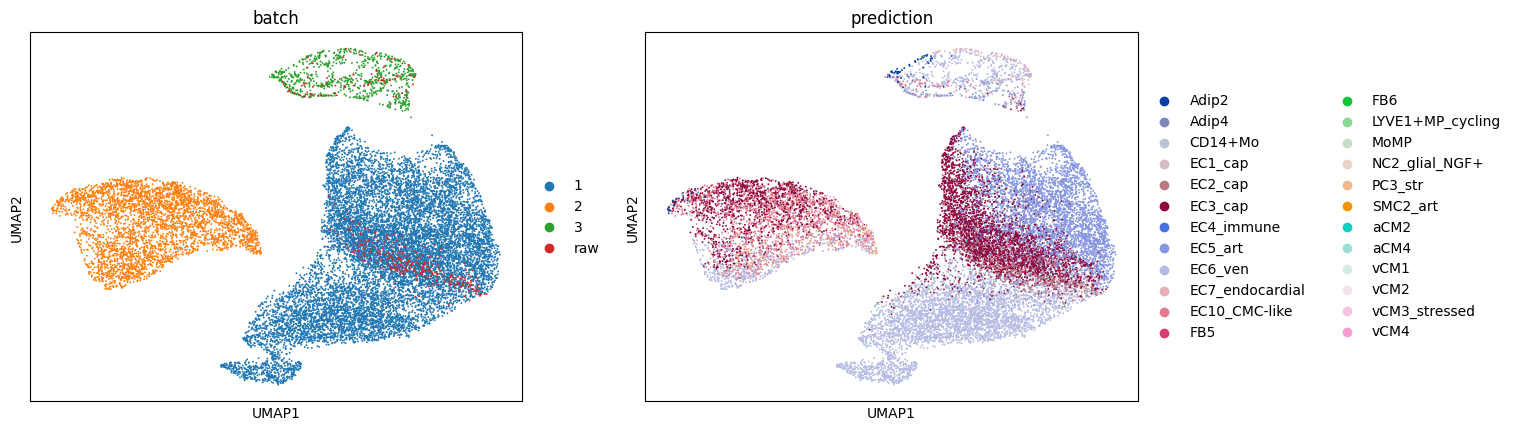

In [9]:
sc.pl.umap(adata_anno2,color=["batch", "prediction"])

In [10]:
pd.crosstab(adata_anno2.obs.prediction, adata_anno2.obs.batch)

batch,1,2,3,raw
prediction,,,,
Adip2,0,31,53,6
Adip4,1,0,0,0
CD14+Mo,8,0,0,0
EC1_cap,99,2,34,65
EC2_cap,777,0,13,63
EC3_cap,2960,1152,8,207
EC4_immune,8,0,0,1
EC5_art,4066,4,106,26
EC6_ven,3834,527,450,19


/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


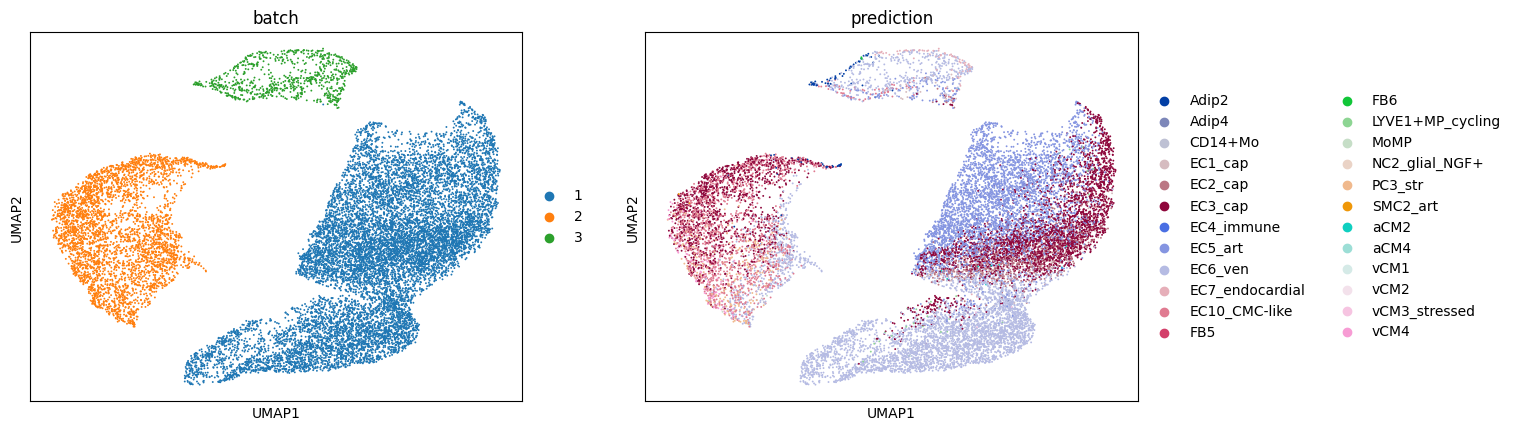

In [13]:
adata = adata_anno2[adata_anno2.obs.batch.isin(['1','2','3'])]
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_pcs=15)
sc.tl.umap(adata)

sc.pl.umap(adata,color=["batch", "prediction"])

In [20]:
import pickle
with open("cellltypist_anno.pkl", "wb") as f:
    pickle.dump( adata.obs.prediction, f)